In [34]:
library(keras)
library(lime)
library(tidyquant)
library(rsample)
library(recipes)
library(yardstick)
library(corrr)

In [36]:
churn_data_raw <- read.csv("d:\\Alldata\\CustomerChurn.csv")

glimpse(churn_data_raw)

Rows: 7,043
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW~
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",~
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes~
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"~
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2~
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", ~
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "~
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt~
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "~
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N~
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y~
$ TechSupport   

In [38]:
churn_data_tbl <- churn_data_raw %>%
  select(-customerID) %>%
  na.omit() %>%
  select(Churn, everything())
    
glimpse(churn_data_tbl)

Rows: 7,032
Columns: 20
$ Churn            <chr> "No", "No", "Yes", "No", "Yes", "Yes", "No", "No", "Y~
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",~
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,~
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes~
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"~
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2~
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", ~
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "~
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt~
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "~
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N~
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y~
$ TechSupport   

In [39]:
set.seed(100)
train_test_split <- initial_split(churn_data_tbl, prop = 0.8)
train_test_split

<Analysis/Assess/Total>
<5625/1407/7032>

In [46]:
train_tbl <- training(train_test_split)
test_tbl  <- testing(train_test_split) 

In [49]:
head(test_tbl)

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
3,Yes,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
8,No,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90
11,No,Male,0,Yes,Yes,13,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45
15,No,Male,0,No,No,25,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,105.50,2686.05
24,No,Female,0,Yes,No,58,Yes,Yes,DSL,No,Yes,No,Yes,No,No,Two year,Yes,Credit card (automatic),59.90,3505.10
36,No,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),99.90,7251.70


In [50]:
train_tbl %>%
  select(Churn, TotalCharges) %>%
  mutate(
      Churn = Churn %>% as.factor() %>% as.numeric(),
      LogTotalCharges = log(TotalCharges)
      ) %>%
  correlate() %>%
  focus(Churn) %>%
  fashion()


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'




term,Churn
<noquote>,<noquote>
TotalCharges,-.21
LogTotalCharges,-.25


In [51]:
# Create recipe
rec_obj <- recipe(Churn ~ ., data = train_tbl) %>%
  step_discretize(tenure, options = list(cuts = 6)) %>%
  step_log(TotalCharges) %>%
  step_dummy(all_nominal(), -all_outcomes()) %>%
  step_center(all_predictors(), -all_outcomes()) %>%
  step_scale(all_predictors(), -all_outcomes()) %>%
  prep(data = train_tbl)

In [52]:
rec_obj

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         19

Training data contained 5625 data points and no missing data.

Operations:

Dummy variables from tenure [trained]
Log transformation on TotalCharges [trained]
Dummy variables from gender, Partner, Dependents, tenure, ... [trained]
Centering for SeniorCitizen, MonthlyCharges, ... [trained]
Scaling for SeniorCitizen, MonthlyCharges, ... [trained]

In [55]:
class(test_tbl)

[1] "data.frame"

In [57]:
x_train_tbl = bake(rec_obj, train_tbl) %>% select(-Churn)
x_test_tbl  = bake(rec_obj, test_tbl ) %>% select(-Churn)
glimpse(x_train_tbl)

Rows: 5,625
Columns: 35
$ SeniorCitizen                         <dbl> -0.442156, -0.442156, -0.442156,~
$ MonthlyCharges                        <dbl> 0.14259354, 0.63931592, 0.215689~
$ TotalCharges                          <dbl> -0.55373663, 0.92162767, -1.2051~
$ gender_Male                           <dbl> 0.9976029, -1.0022247, 0.9976029~
$ Partner_Yes                           <dbl> -0.9675486, 1.0333561, -0.967548~
$ Dependents_Yes                        <dbl> -0.6533489, 1.5303038, -0.653348~
$ tenure_bin1                           <dbl> -0.4655146, -0.4655146, 2.147778~
$ tenure_bin2                           <dbl> 2.3328805, -0.4285784, -0.428578~
$ tenure_bin3                           <dbl> -0.4558752, -0.4558752, -0.45587~
$ tenure_bin4                           <dbl> -0.4484611, -0.4484611, -0.44846~
$ tenure_bin5                           <dbl> -0.4493186, 2.2251967, -0.449318~
$ tenure_bin6                           <dbl> -0.434953, -0.434953, -0.434953,~
$ PhoneService_Y

In [58]:
y_train_vec <- ifelse(pull(train_tbl, Churn) == "Yes", 1, 0)
y_test_vec  <- ifelse(pull(test_tbl, Churn) == "Yes", 1, 0)

In [59]:
model_keras <- keras_model_sequential()

In [61]:
model_keras %>% 
  
  # First hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu", 
    input_shape        = ncol(x_train_tbl)) %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Second hidden layer
  layer_dense(
    units              = 16, 
    kernel_initializer = "uniform", 
    activation         = "relu") %>% 
  
  # Dropout to prevent overfitting
  layer_dropout(rate = 0.1) %>%
  
  # Output layer
  layer_dense(
    units              = 1, 
    kernel_initializer = "uniform", 
    activation         = "sigmoid") %>% 
  
  # Compile ANN
  compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy',
    metrics   = c('accuracy')
  )



In [63]:
model_keras

Model
Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_5 (Dense)                     (None, 16)                      576         
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 16)                      272         
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 16)                      0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       17          
________________________________________________________________________________


In [64]:
# Fit the keras model to the training data
history <- fit(
  object           = model_keras, 
  x                = as.matrix(x_train_tbl), 
  y                = y_train_vec,
  batch_size       = 50, 
  epochs           = 35,
  validation_split = 0.30
)

In [65]:
print(history)


Final epoch (plot to see history):
        loss: 0.4035
    accuracy: 0.8151
    val_loss: 0.4523
val_accuracy: 0.7802 


`geom_smooth()` using formula 'y ~ x'



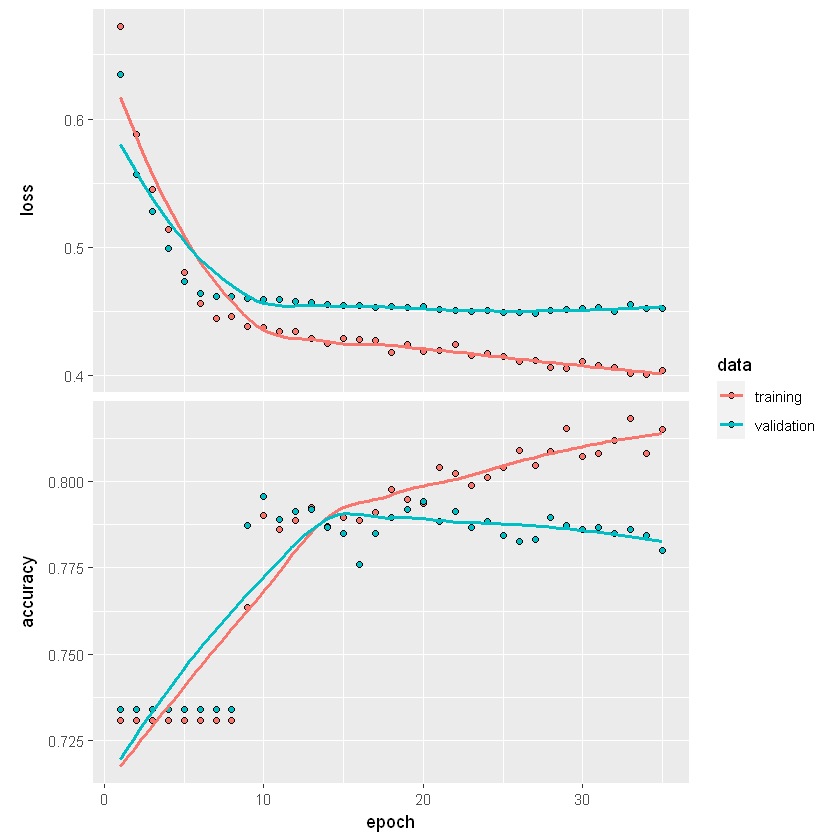

In [66]:
plot(history) 

In [67]:
# Predicted Class
yhat_keras_class_vec <- predict_classes(object = model_keras, x = as.matrix(x_test_tbl)) %>%
    as.vector()

# Predicted Class Probability
yhat_keras_prob_vec  <- predict_proba(object = model_keras, x = as.matrix(x_test_tbl)) %>%
    as.vector()

Warning message in predict_classes(object = model_keras, x = as.matrix(x_test_tbl)):
"`predict_classes()` is deprecated and and was removed from tensorflow in version 2.6.
Please update your code:
  * If your model does multi-class classification:
    (e.g. if it uses a `softmax` last-layer activation).

      model %>% predict(x) %>% k_argmax()

  * if your model does binary classification
    (e.g. if it uses a `sigmoid` last-layer activation).

      model %>% predict(x) %>% `>`(0.5) %>% k_cast("int32")
"
Warning message in predict_proba(object = model_keras, x = as.matrix(x_test_tbl)):
"`predict_proba()` is deprecated and was removed from tensorflow in version 2.6, please use `predict()` instead"


In [69]:
library(forcats)

Warning message:
"package 'forcats' was built under R version 4.0.5"


In [70]:
# Format test data and predictions for yardstick metrics
estimates_keras_tbl <- tibble(
  truth      = as.factor(y_test_vec) %>% fct_recode(yes = "1", no = "0"),
  estimate   = as.factor(yhat_keras_class_vec) %>% fct_recode(yes = "1", no = "0"),
  class_prob = yhat_keras_prob_vec
)

estimates_keras_tbl

truth,estimate,class_prob
<fct>,<fct>,<dbl>
yes,no,0.19383320
no,no,0.43242797
no,no,0.15137142
no,no,0.49932885
no,no,0.02489254
no,no,0.03075412
no,no,0.02512750
no,no,0.41819987
no,yes,0.54757094


In [71]:
options(yardstick.event_first = FALSE)

In [72]:
# Confusion Table
estimates_keras_tbl %>% conf_mat(truth, estimate)

          Truth
Prediction  no yes
       no  866 136
       yes 181 224

In [73]:
estimates_keras_tbl %>% metrics(truth, estimate)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7746979
kap,binary,0.4316455


In [74]:
# AUC
estimates_keras_tbl %>% roc_auc(truth, class_prob)

Warning message:
"The `yardstick.event_first` option has been deprecated as of yardstick 0.0.7 and will be completely ignored in a future version.
Instead, set the following argument directly in the metric function:
`options(yardstick.event_first = TRUE)`  -> `event_level = 'first'` (the default)
`options(yardstick.event_first = FALSE)` -> `event_level = 'second'`
This warning is displayed once per session."


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
roc_auc,binary,0.8227581


In [75]:
# Precision
tibble(
  precision = estimates_keras_tbl %>% precision(truth, estimate),
  recall    = estimates_keras_tbl %>% recall(truth, estimate)
)

ERROR while rich displaying an object: Error in vapply(part, function(col) {: values must be length 1,
 but FUN(X[[1]]) result is length 4

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[m

In [76]:
# F1-Statistic
estimates_keras_tbl %>% f_meas(truth, estimate, beta = 1)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
f_meas,binary,0.5856209


ERROR: Error in fct_recode(., yes = "1", no = "0"): could not find function "fct_recode"


In [77]:
"Happy ML"

[1] "Happy ML"